In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  ghostscript libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lilypond-data lilypond-fonts lmodern poppler-data
  t1utils tex-common texlive-base texlive-binaries texlive-latex-base
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x lilypond-doc python3-lxml poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-n

In [3]:
import torch
import numpy as np
import pandas
import music21
from music21 import *
import os
import IPython
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
path = 'drive/MyDrive/Colab Notebooks/PROGETTO SOUND COMPUTING/mozart'
all_midis = []

for i in os.listdir(path):
    if i.endswith('.mid'):
        tr = os.path.join(path, i)
        try:
            midi = music21.converter.parse(tr)
            all_midis.append(midi)
        except Exception as e:
            print(f"Error loading {tr}: {e}")

print(f"Loaded {len(all_midis)} MIDI files.")


/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2005 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiE

Loaded 21 MIDI files.


In [5]:
def extract_notes(file):
    notes = []
    pick = None
    for f in file:
        song = instrument.partitionByInstrument(f)
        for part in song.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes
notes = extract_notes(all_midis)
print(len(notes))

55802


In [6]:
def show(music):
    music.write('midi', 'drive/MyDrive/Colab Notebooks/PROGETTO SOUND COMPUTING/output.mid')

def chords_n_notes(notes):
    melody = []
    offset = 0
    for n in notes:
        if ('.' in n) or n.isdigit():
            chord_notes = n.split('.')
            note_objs = [note.Note(int(j)) for j in chord_notes]
            chord_snip = chord.Chord(note_objs)
            chord_snip.offset = offset
            melody.append(chord_snip)
        else:
            note_snip = note.Note(n)
            note_snip.offset = offset
            melody.append(note_snip)
        offset += 1

    melody_midi = stream.Stream(melody)
    return melody_midi

# melody_midi = chords_n_notes(notes)
# show(melody_midi)


In [7]:
count_num = Counter(notes)
print("Total unique notes in the Corpus:", len(count_num))
keys = list(count_num.keys())
values = list(count_num.values())

def average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", average(values))
print("Most frequent note in Corpus appeared:", max(values), "times")
print("Least frequent note in Corpus appeared:", min(values), "time")

Total unique notes in the Corpus: 229
Average recurrenc for a note in Corpus: 243.6768558951965
Most frequent note in Corpus appeared: 2355 times
Least frequent note in Corpus appeared: 1 time


In [8]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 20:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 94


In [9]:
symb = sorted(list(set(notes)))

L_corpus = len(notes)
L_symb = len(symb)

mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 55802
Number of unique characters: 229


In [10]:
length = 30
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = notes[i:i + length]
    target = notes[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 55772


In [11]:
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
y = torch.nn.functional.one_hot(torch.tensor(targets))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
y_train_tensor = torch.argmax(y_train_tensor, dim=1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val)
y_val_tensor = torch.argmax(y_val_tensor, dim=1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)
y_test_tensor = torch.argmax(y_test_tensor, dim=1)

<ipython-input-13-99bc6284ed0d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train)
<ipython-input-13-99bc6284ed0d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val)
<ipython-input-13-99bc6284ed0d>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test)


In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_1=512, hidden_size_2=512, dropout_rate=0.3, output_size=None):
        super(LSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size_1, num_layers=3, batch_first=True, bidirectional=True)
        self.norm1 = nn.LayerNorm(hidden_size_1 * 2)

        # self.lstm2 = nn.LSTM(hidden_size_1 * 2, hidden_size_2, batch_first=True, bidirectional=True)
        # self.norm2 = nn.LayerNorm(hidden_size_2 * 2)

        # self.lstm3 = nn.LSTM(hidden_size_2 * 2, hidden_size_2, num_layers=3, batch_first=True, bidirectional=True)
        # self.norm3 = nn.LayerNorm(hidden_size_2*2)

        self.bn1 = nn.BatchNorm1d(hidden_size_2*2)
        self.fc1 = nn.Linear(hidden_size_2 * 2, hidden_size_2)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size_2, hidden_size_2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size_2, hidden_size_2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size_2, output_size),
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        # self.fc2 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.norm1(x)

        # x, _ = self.lstm2(x)
        # x = self.norm2(x)

        # x, _ = self.lstm3(x)
        # x = self.norm3(x)

        x = x[:, -1, :]
        x = self.bn1(x)
        x = F.gelu(self.fc1(x))
        x = self.dropout2(x)

        x = self.mlp(x)

        return x


Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200


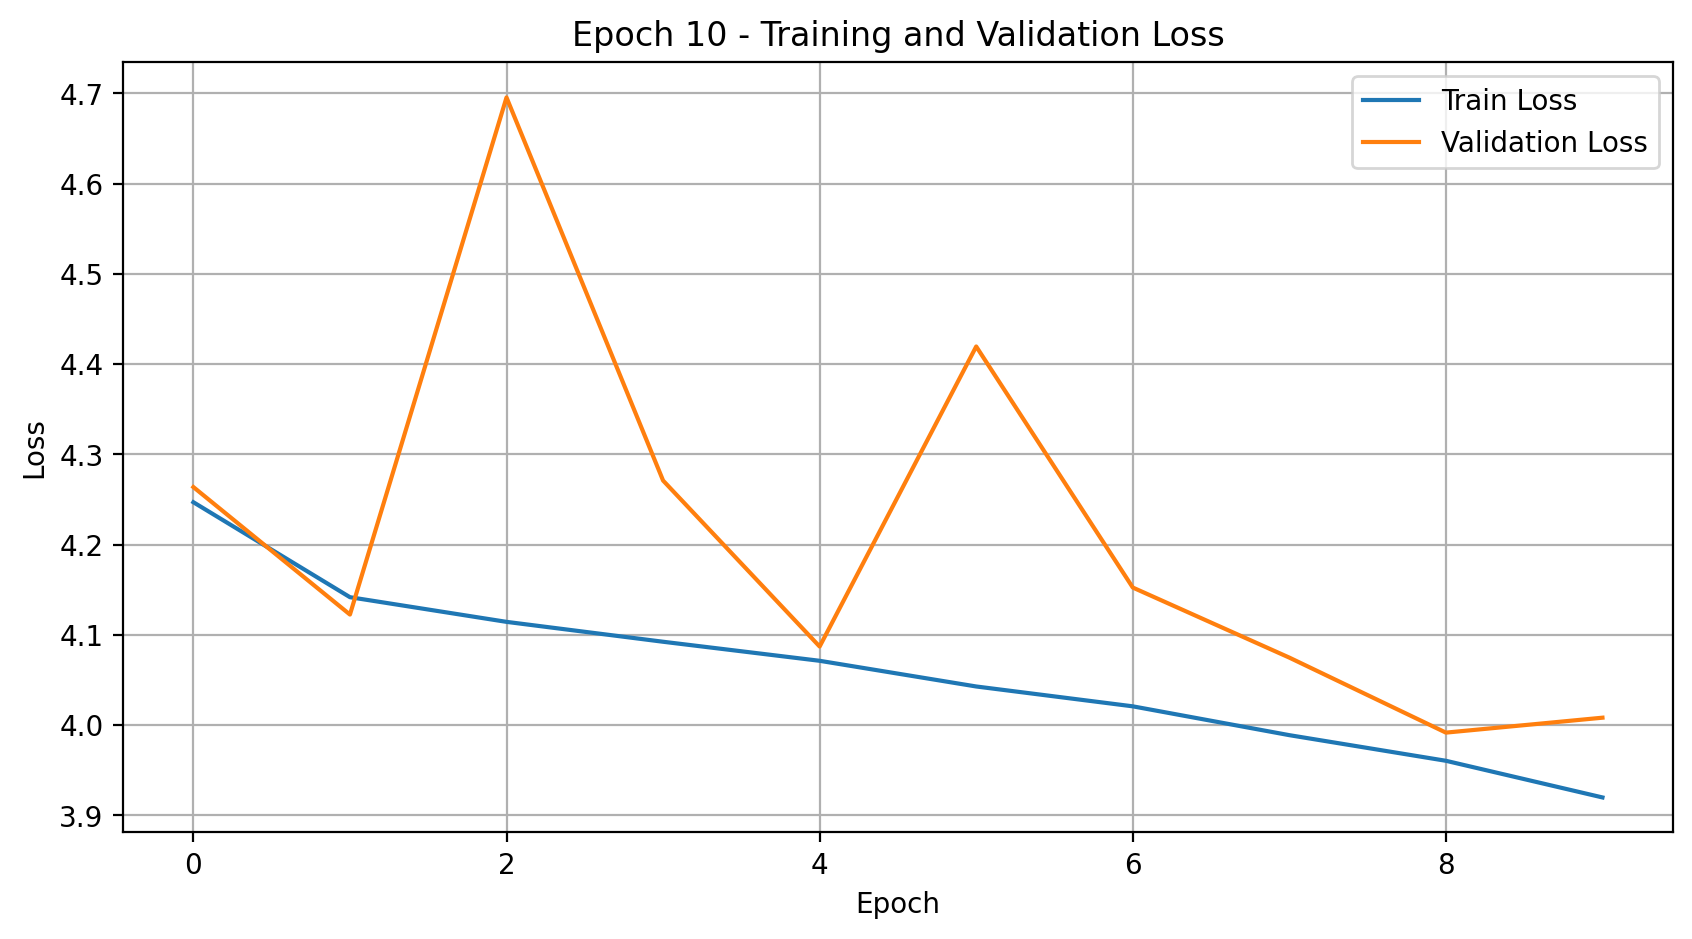

Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200


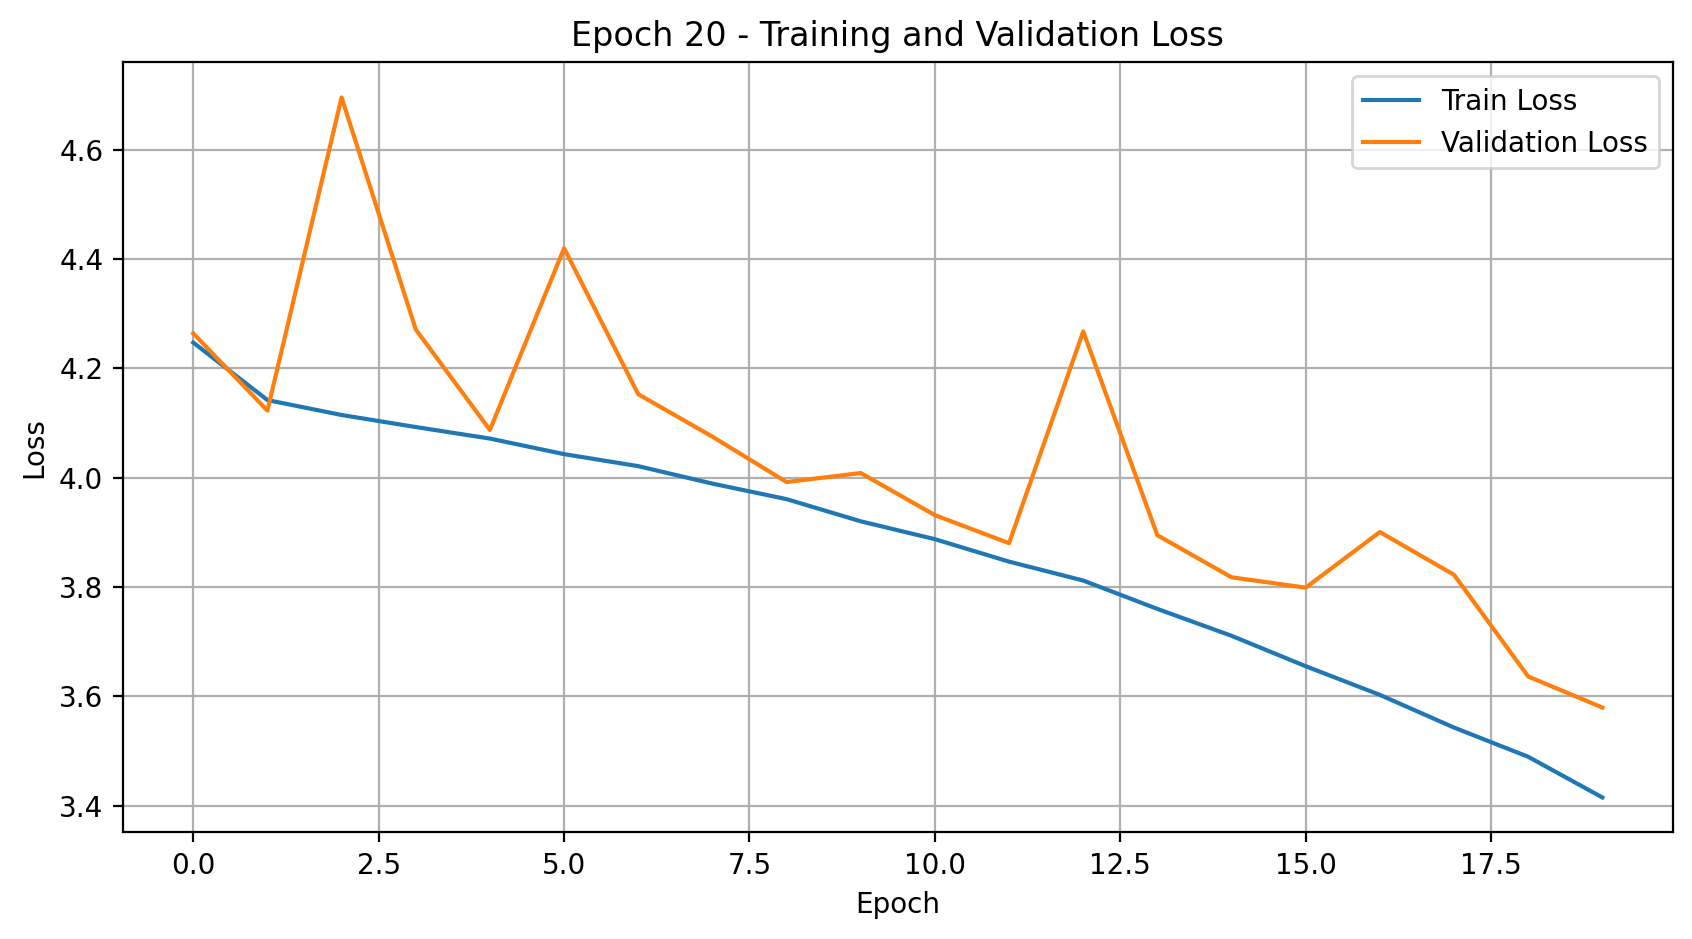

Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200


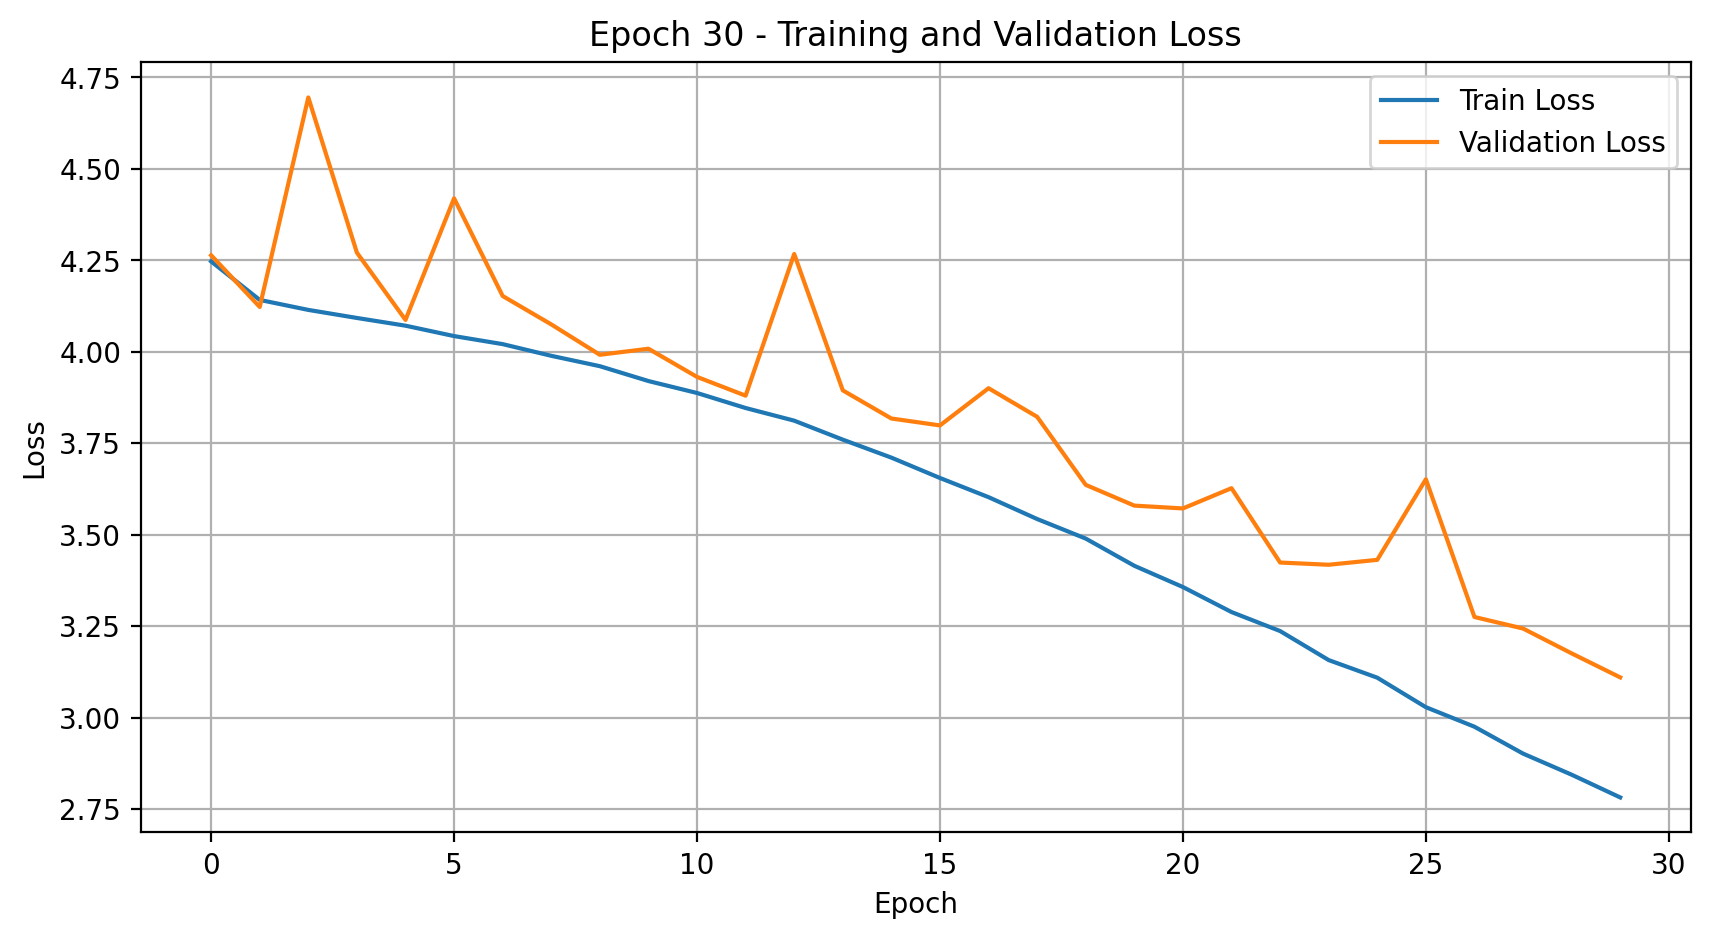

Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200


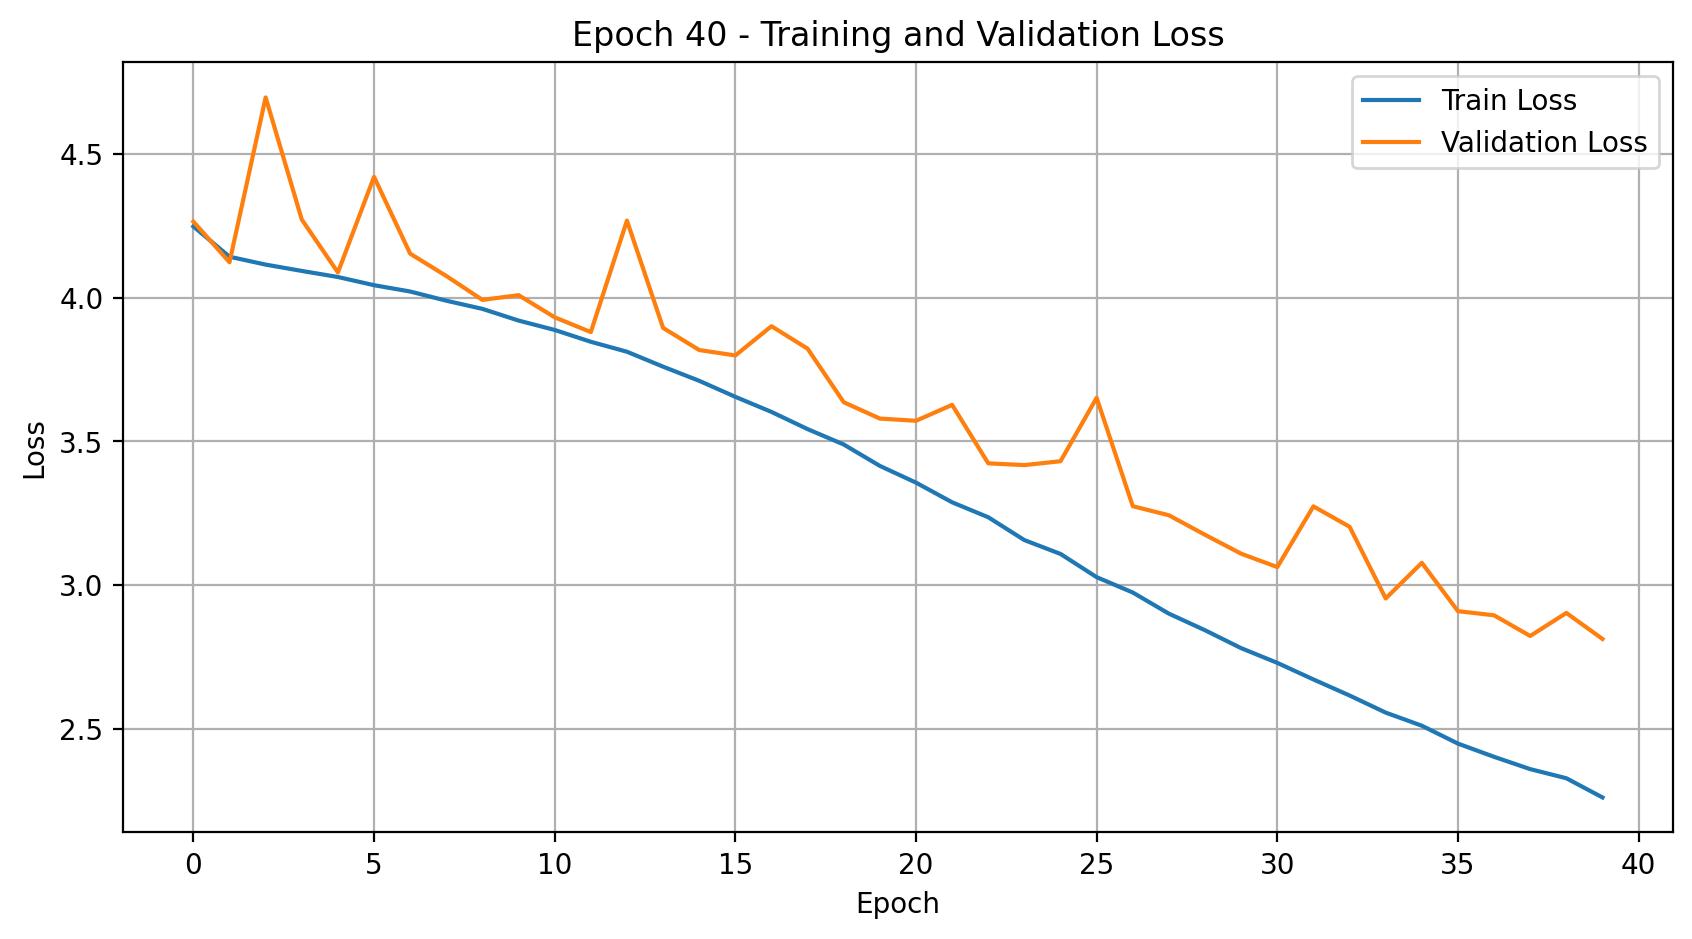

Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200


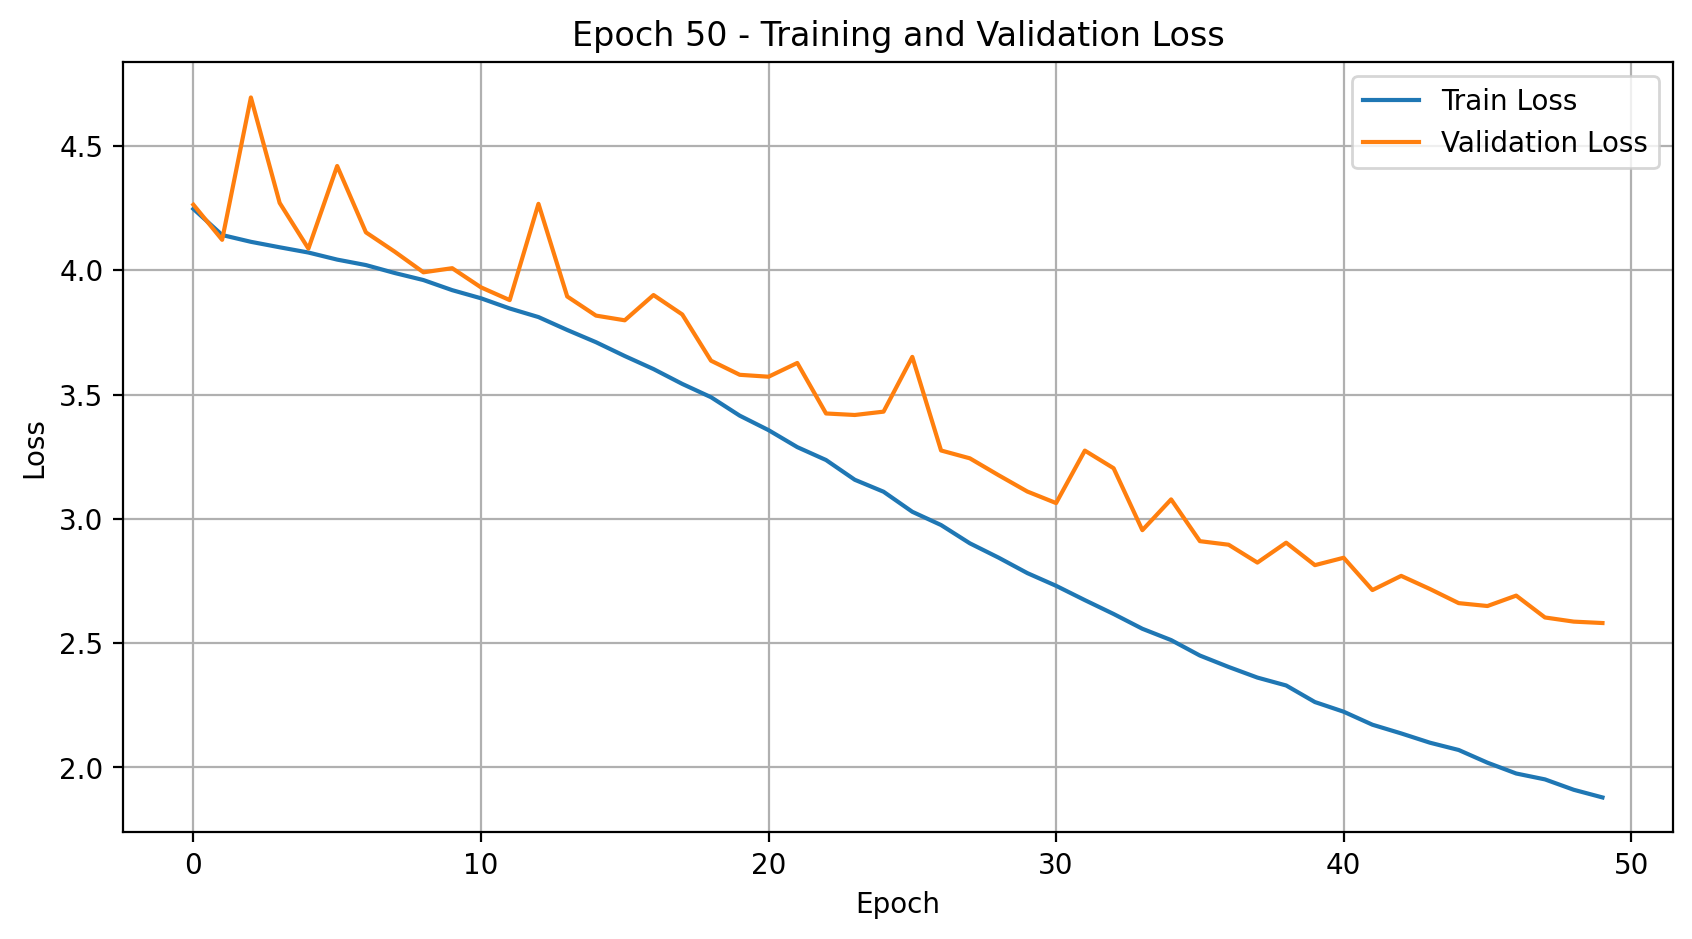

Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200


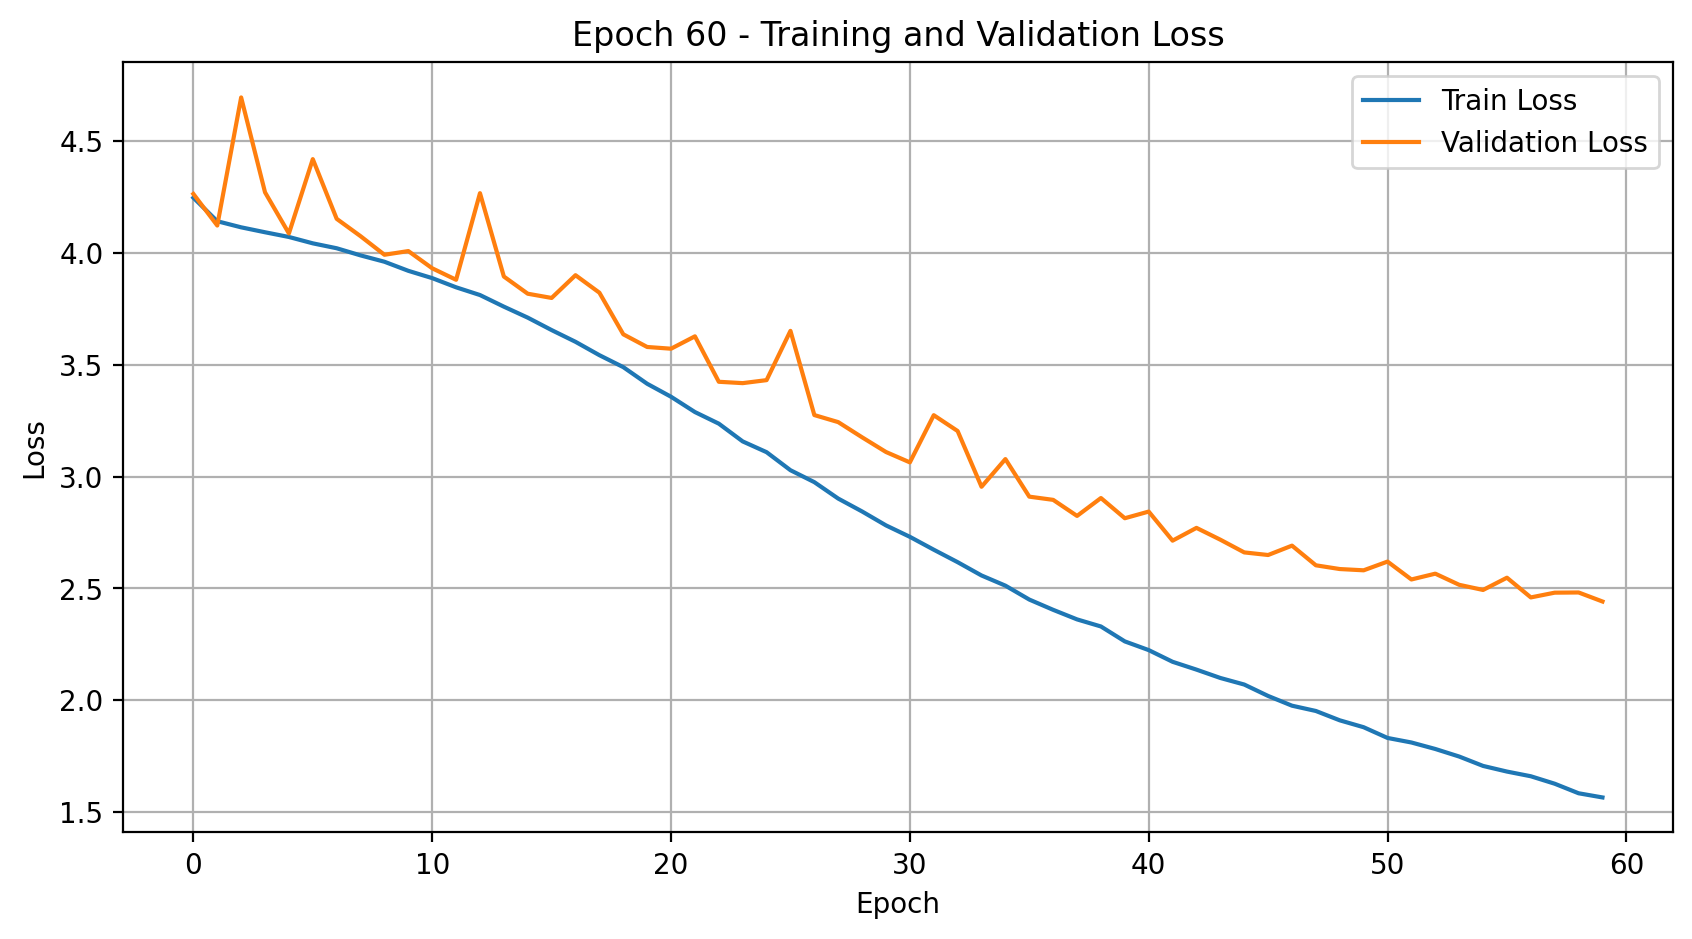

Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200


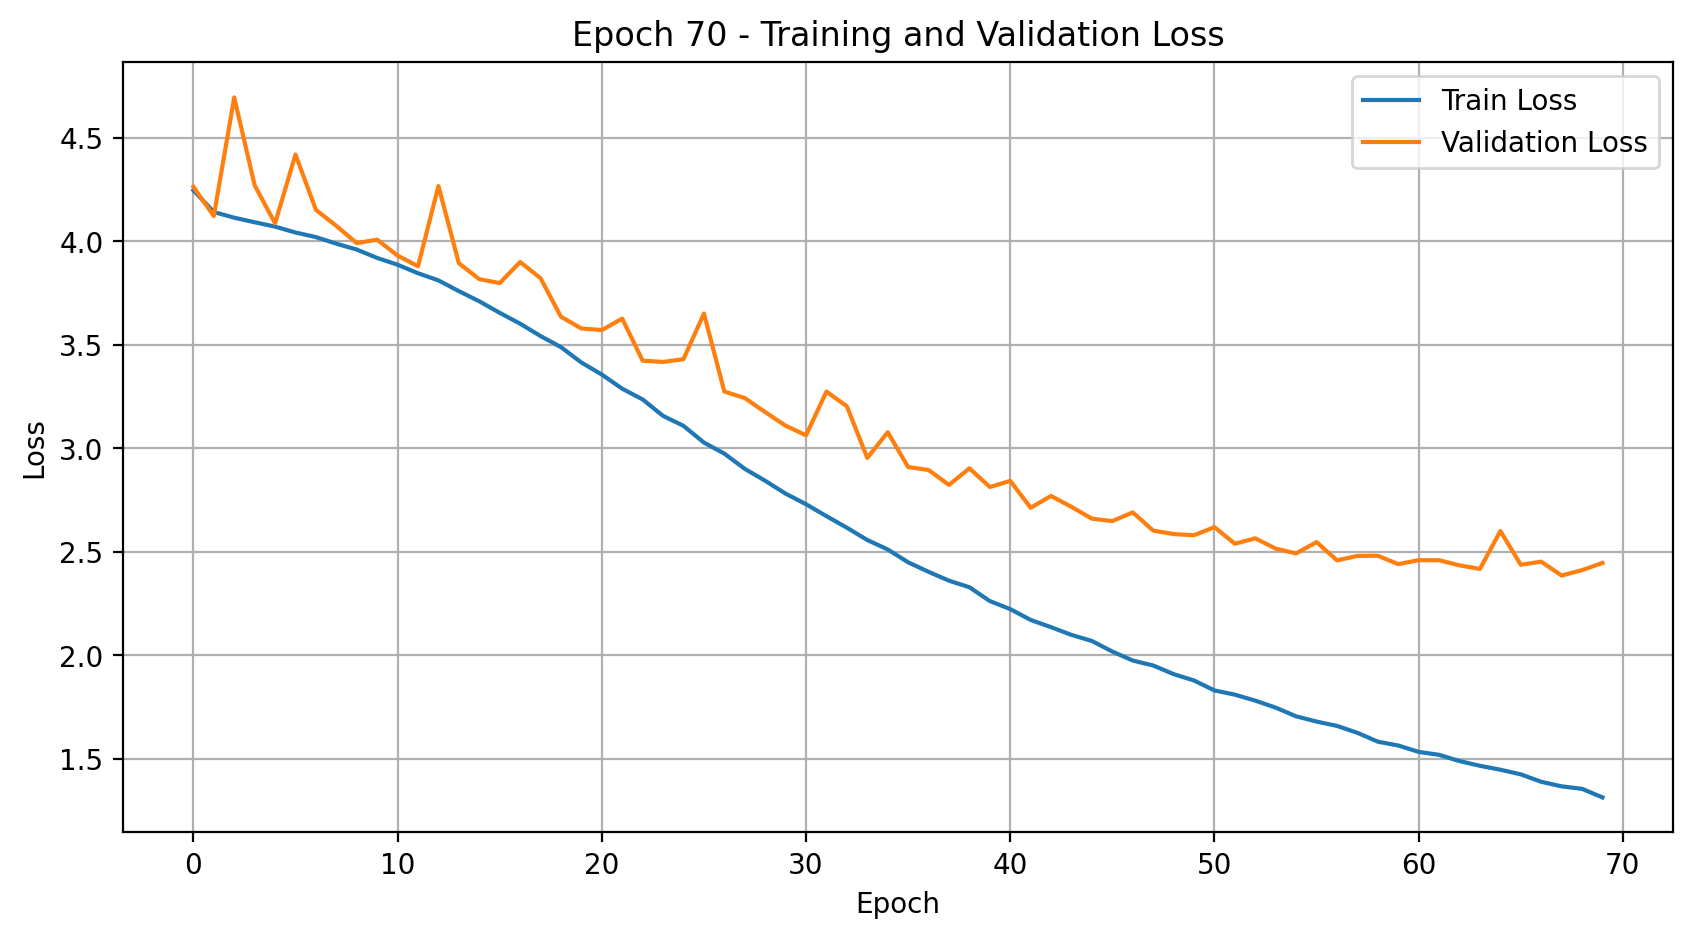

Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78/200
Epoch 79/200
Epoch 80/200


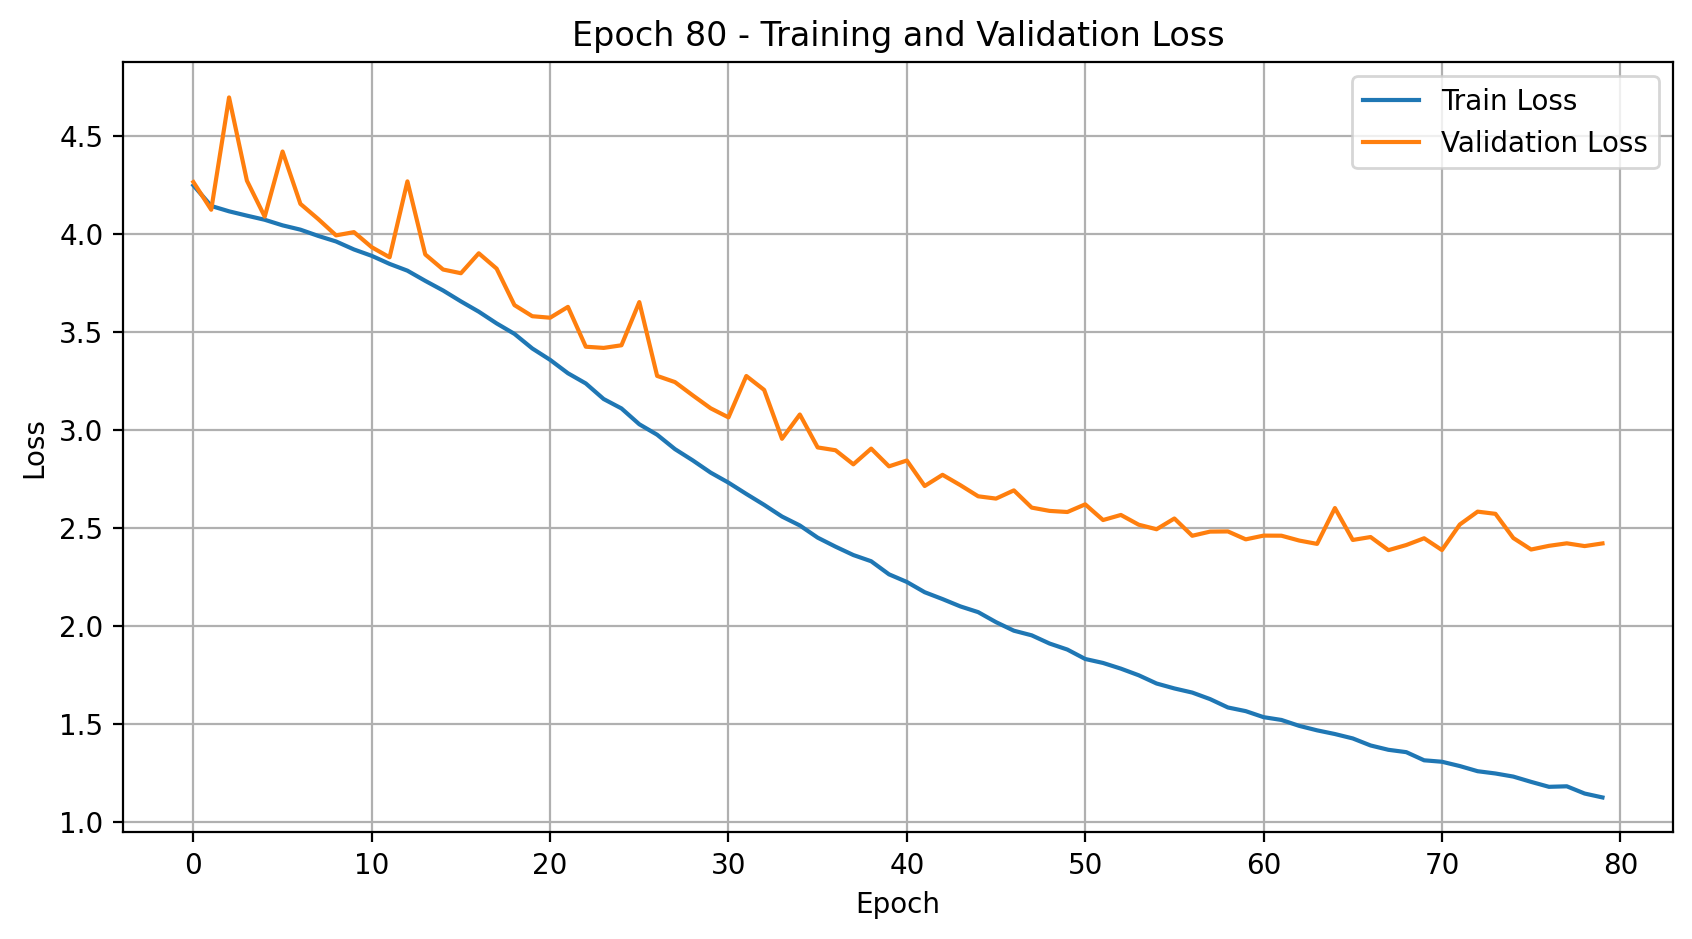

Epoch 81/200
Epoch 82/200
Epoch 83/200
Epoch 84/200
Epoch 85/200
Epoch 86/200
Epoch 87/200
Epoch 88/200
Epoch 89/200
Epoch 90/200


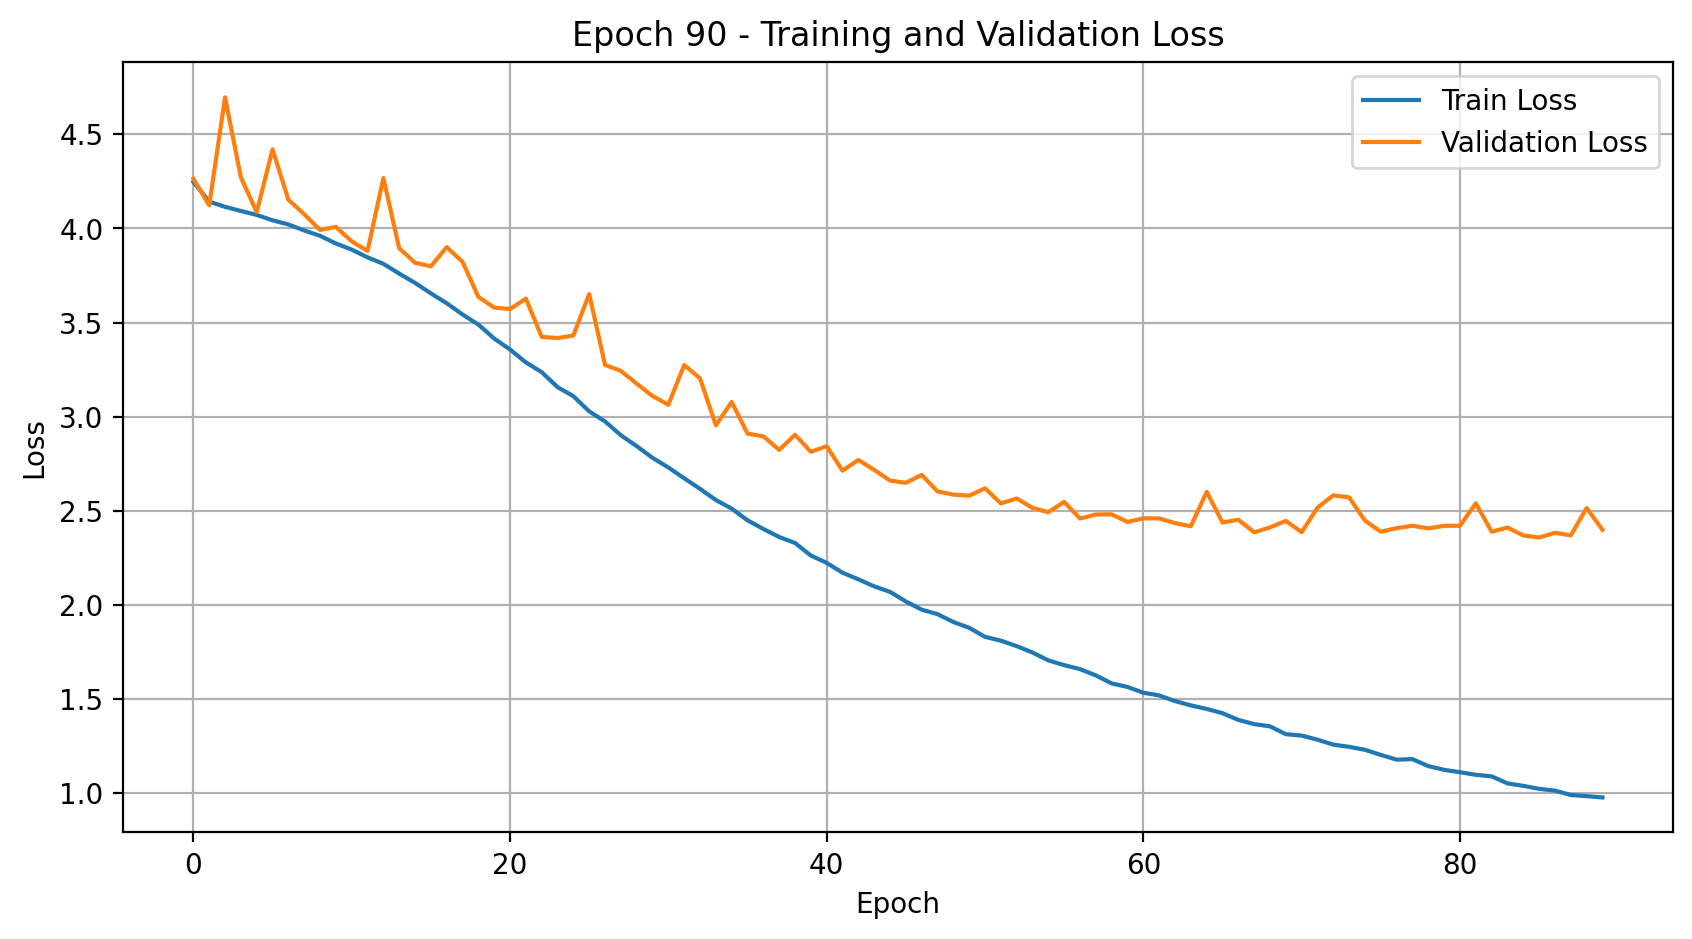

Epoch 91/200
Epoch 92/200
Epoch 93/200
Epoch 94/200
Epoch 95/200
Epoch 96/200
Epoch 97/200
Epoch 98/200
Epoch 99/200
Epoch 100/200


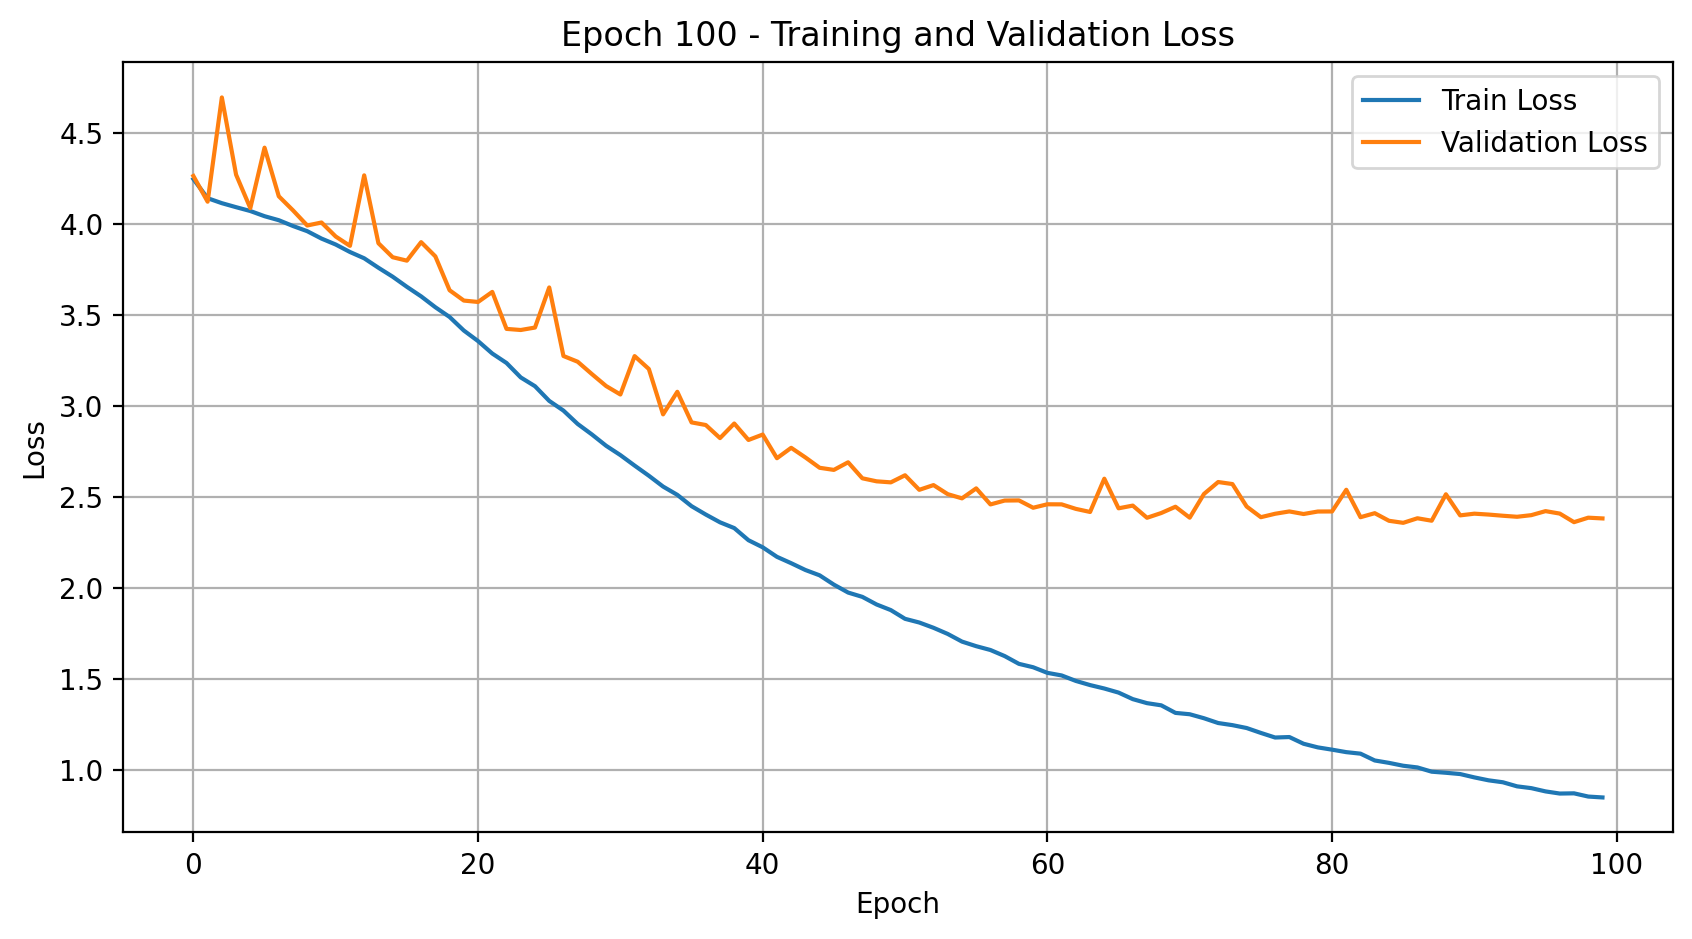

Epoch 101/200
Epoch 102/200
Epoch 103/200
Epoch 104/200
Epoch 105/200
Epoch 106/200
Epoch 107/200
Epoch 108/200
Epoch 109/200
Epoch 110/200


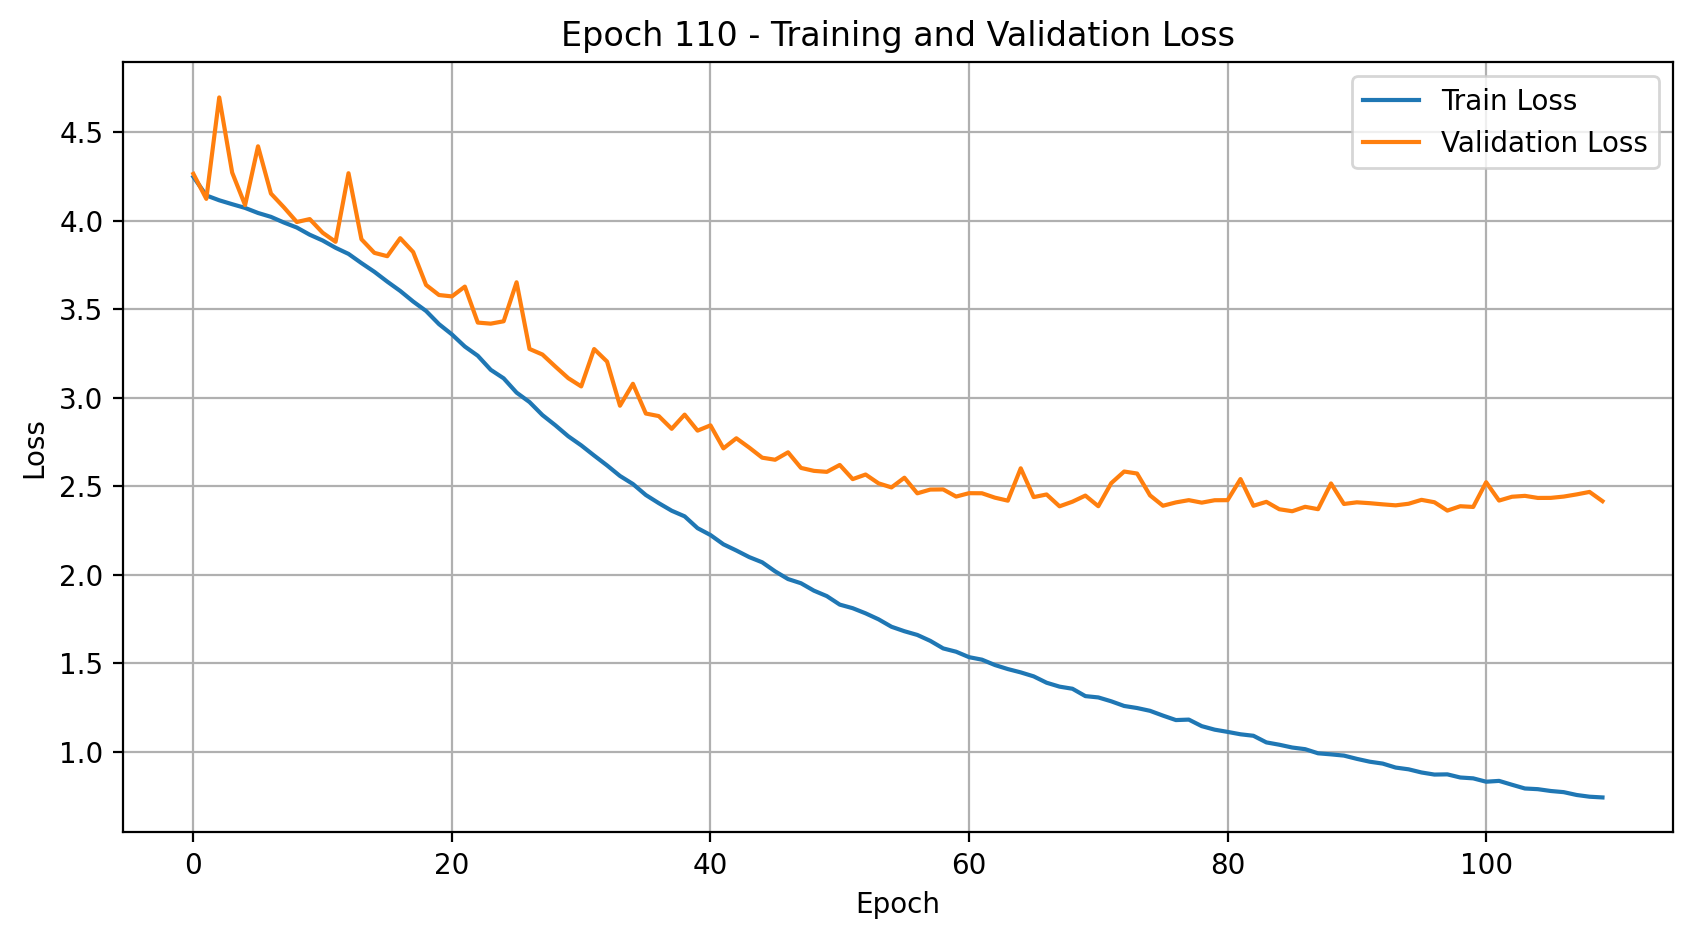

Epoch 111/200
Epoch 112/200
Epoch 113/200
Epoch 114/200
Epoch 115/200
Epoch 116/200
Epoch 117/200
Epoch 118/200
Epoch 119/200
Epoch 120/200


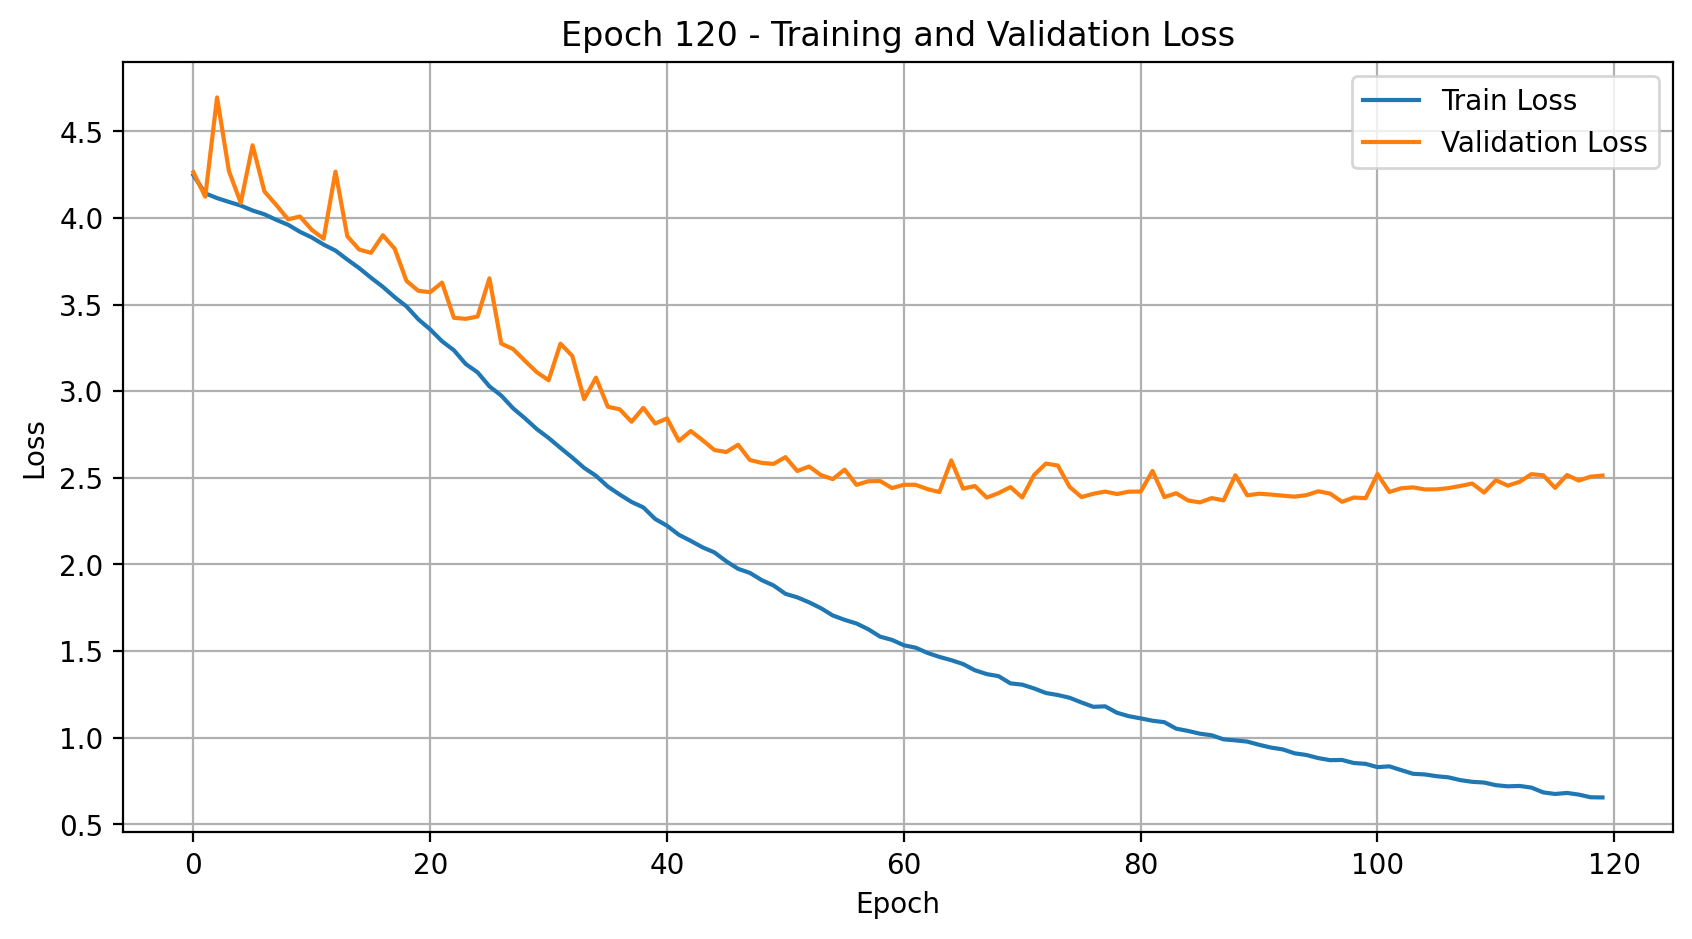

Epoch 121/200
Epoch 122/200
Epoch 123/200
Epoch 124/200
Epoch 125/200
Epoch 126/200
Epoch 127/200
Epoch 128/200
Epoch 129/200
Epoch 130/200


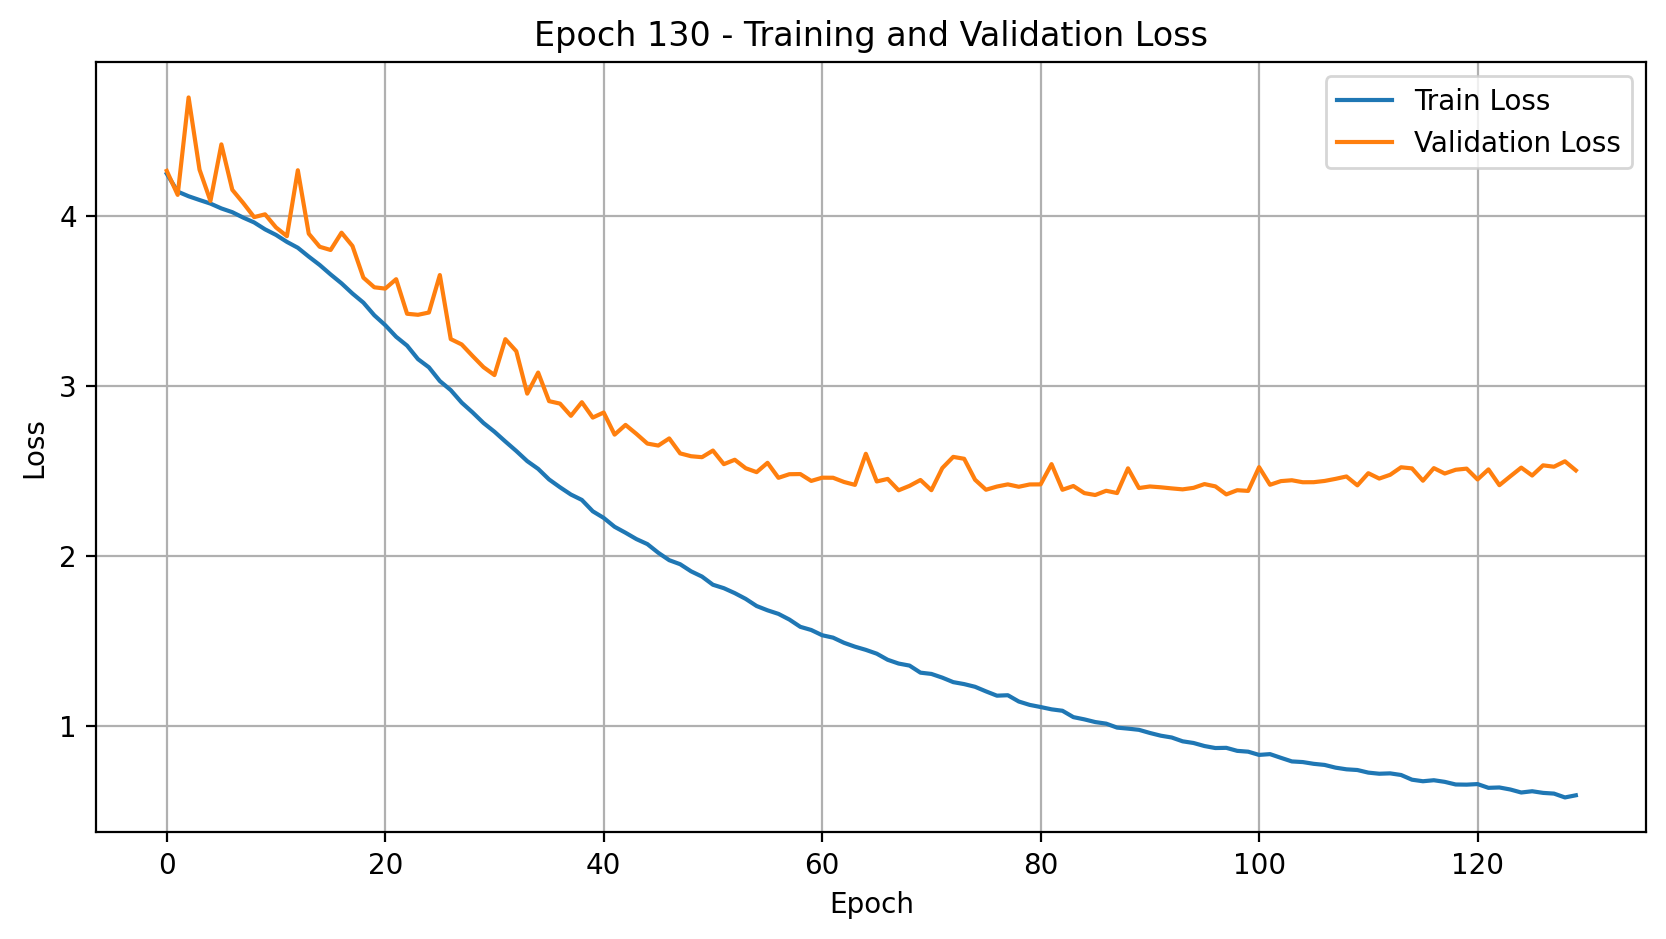

Epoch 131/200
Epoch 132/200
Epoch 133/200
Epoch 134/200
Epoch 135/200
Epoch 136/200
Epoch 137/200
Epoch 138/200
Epoch 139/200
Epoch 140/200


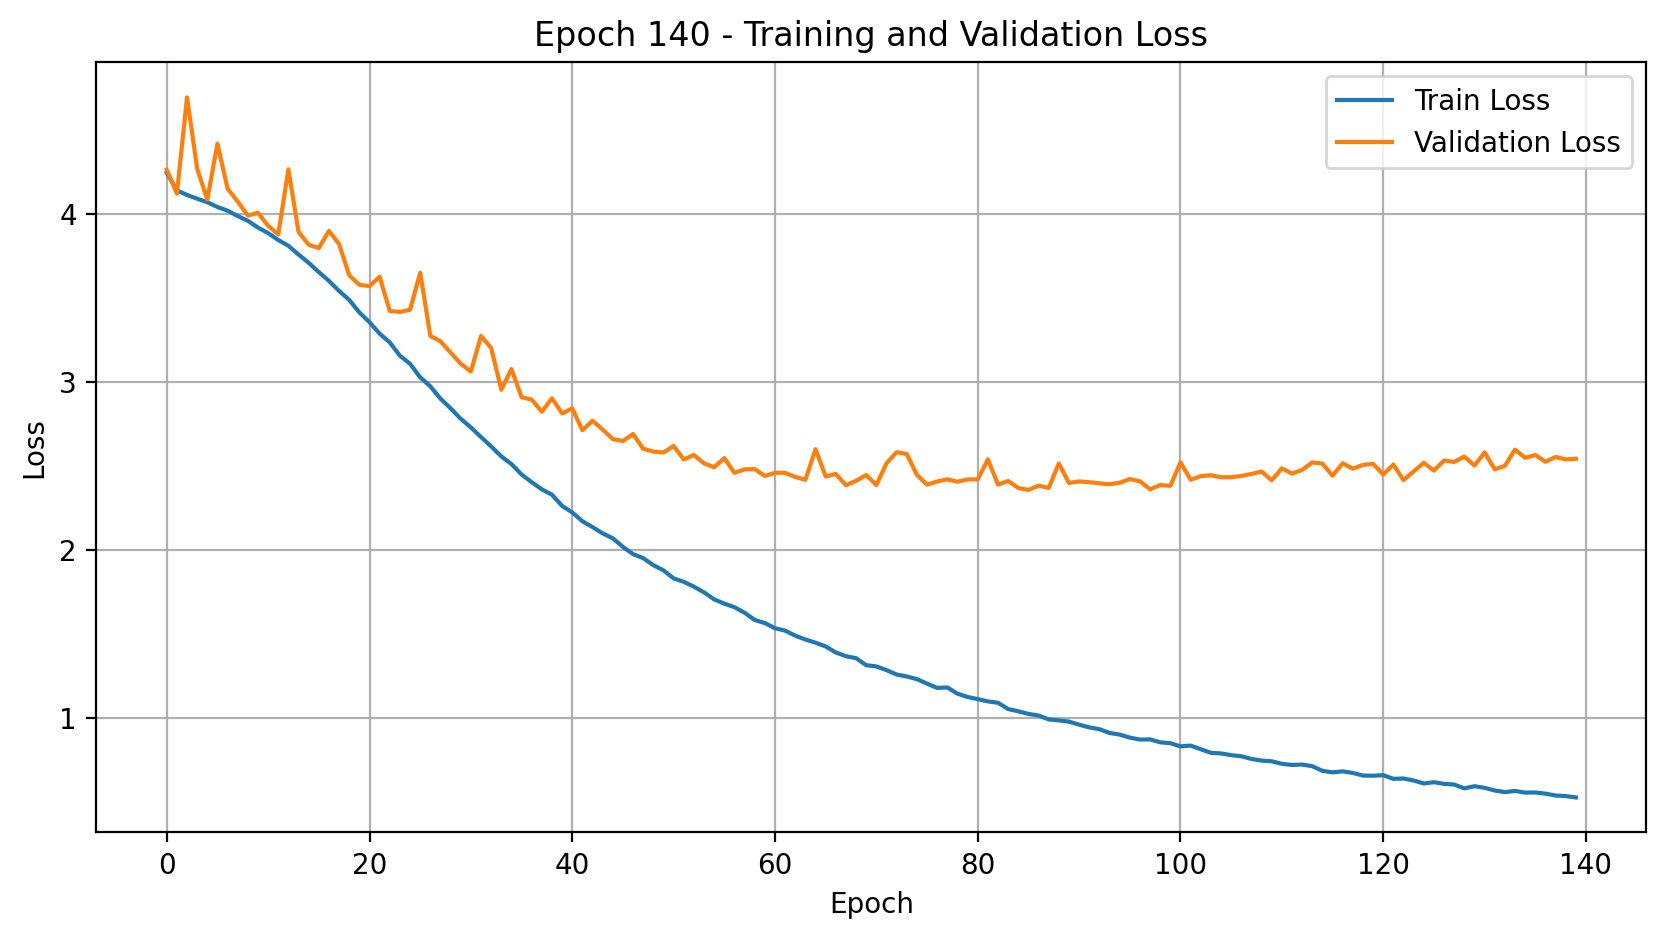

Epoch 141/200
Epoch 142/200
Epoch 143/200
Epoch 144/200
Epoch 145/200
Epoch 146/200
Epoch 147/200
Epoch 148/200
Epoch 149/200
Epoch 150/200


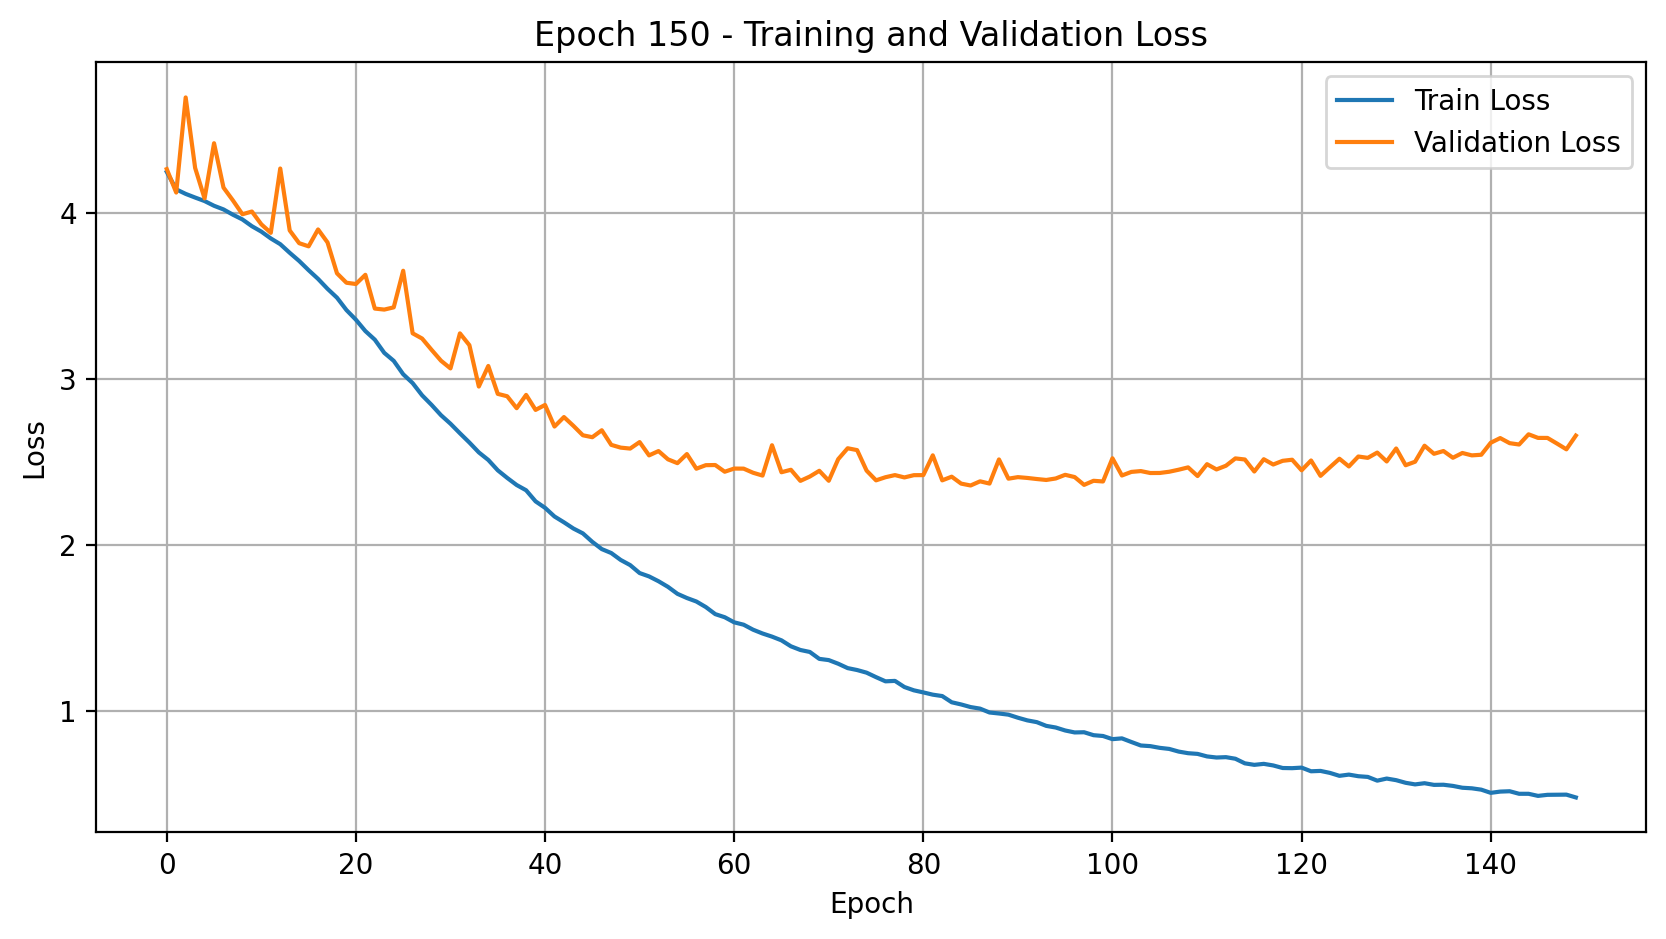

Epoch 151/200
Epoch 152/200
Epoch 153/200
Epoch 154/200
Epoch 155/200
Epoch 156/200
Epoch 157/200
Epoch 158/200
Epoch 159/200
Epoch 160/200


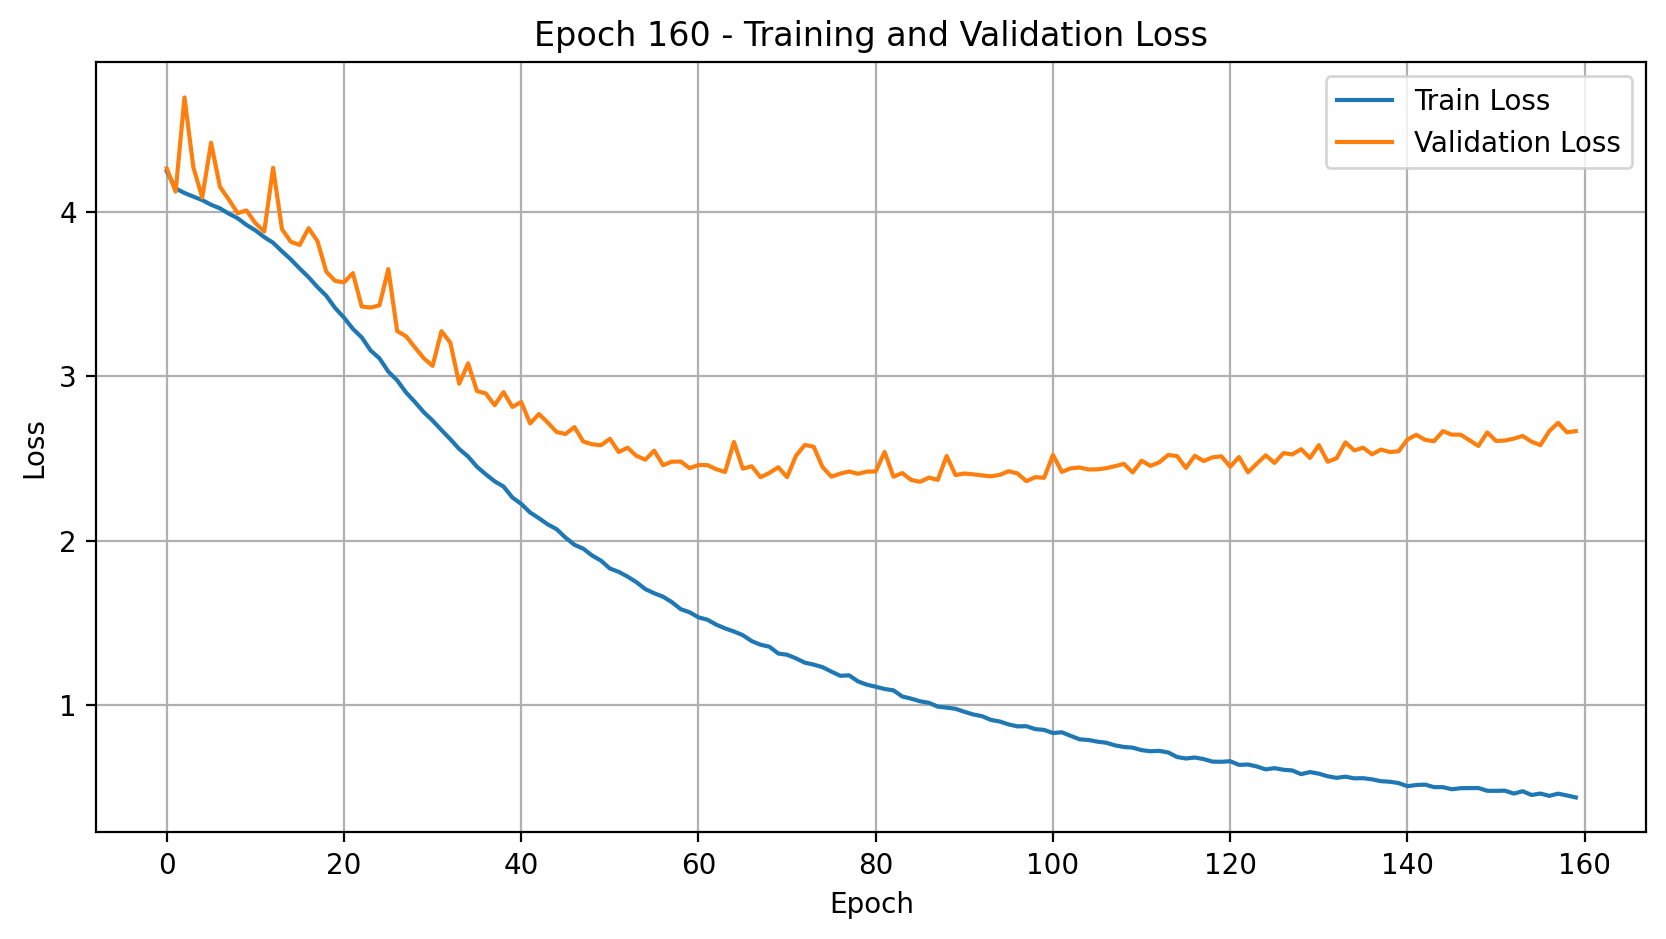

Epoch 161/200
Epoch 162/200
Epoch 163/200
Epoch 164/200
Epoch 165/200
Epoch 166/200
Epoch 167/200
Epoch 168/200
Epoch 169/200
Epoch 170/200


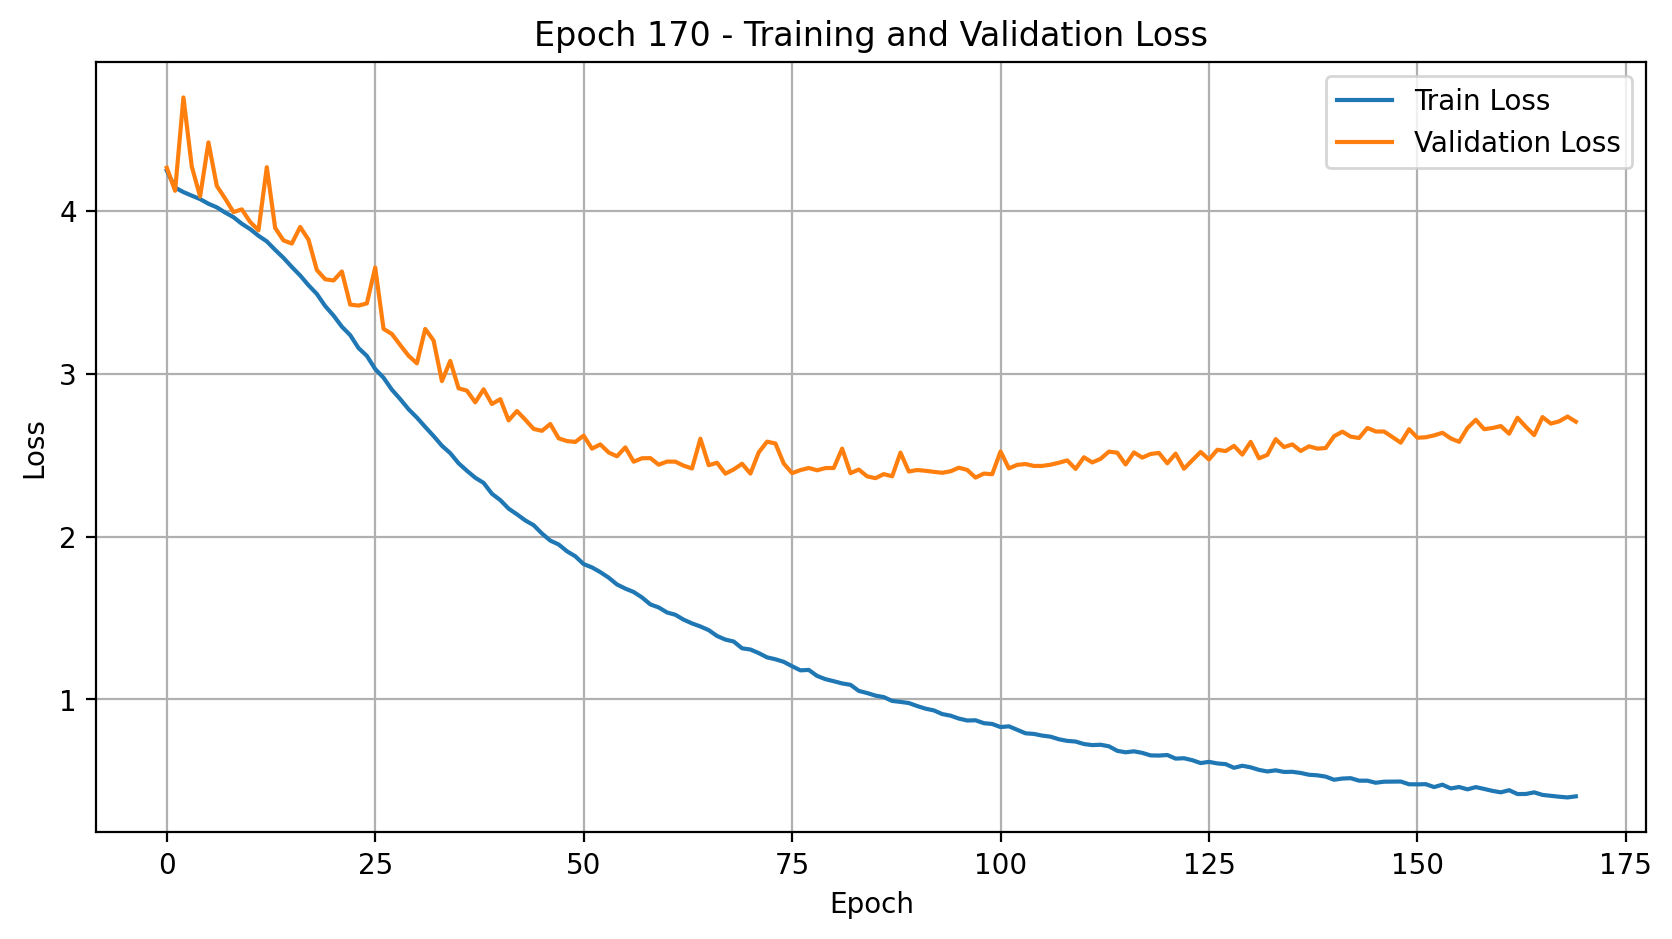

Epoch 171/200
Epoch 172/200
Epoch 173/200
Epoch 174/200
Epoch 175/200
Epoch 176/200
Epoch 177/200
Epoch 178/200
Epoch 179/200
Epoch 180/200


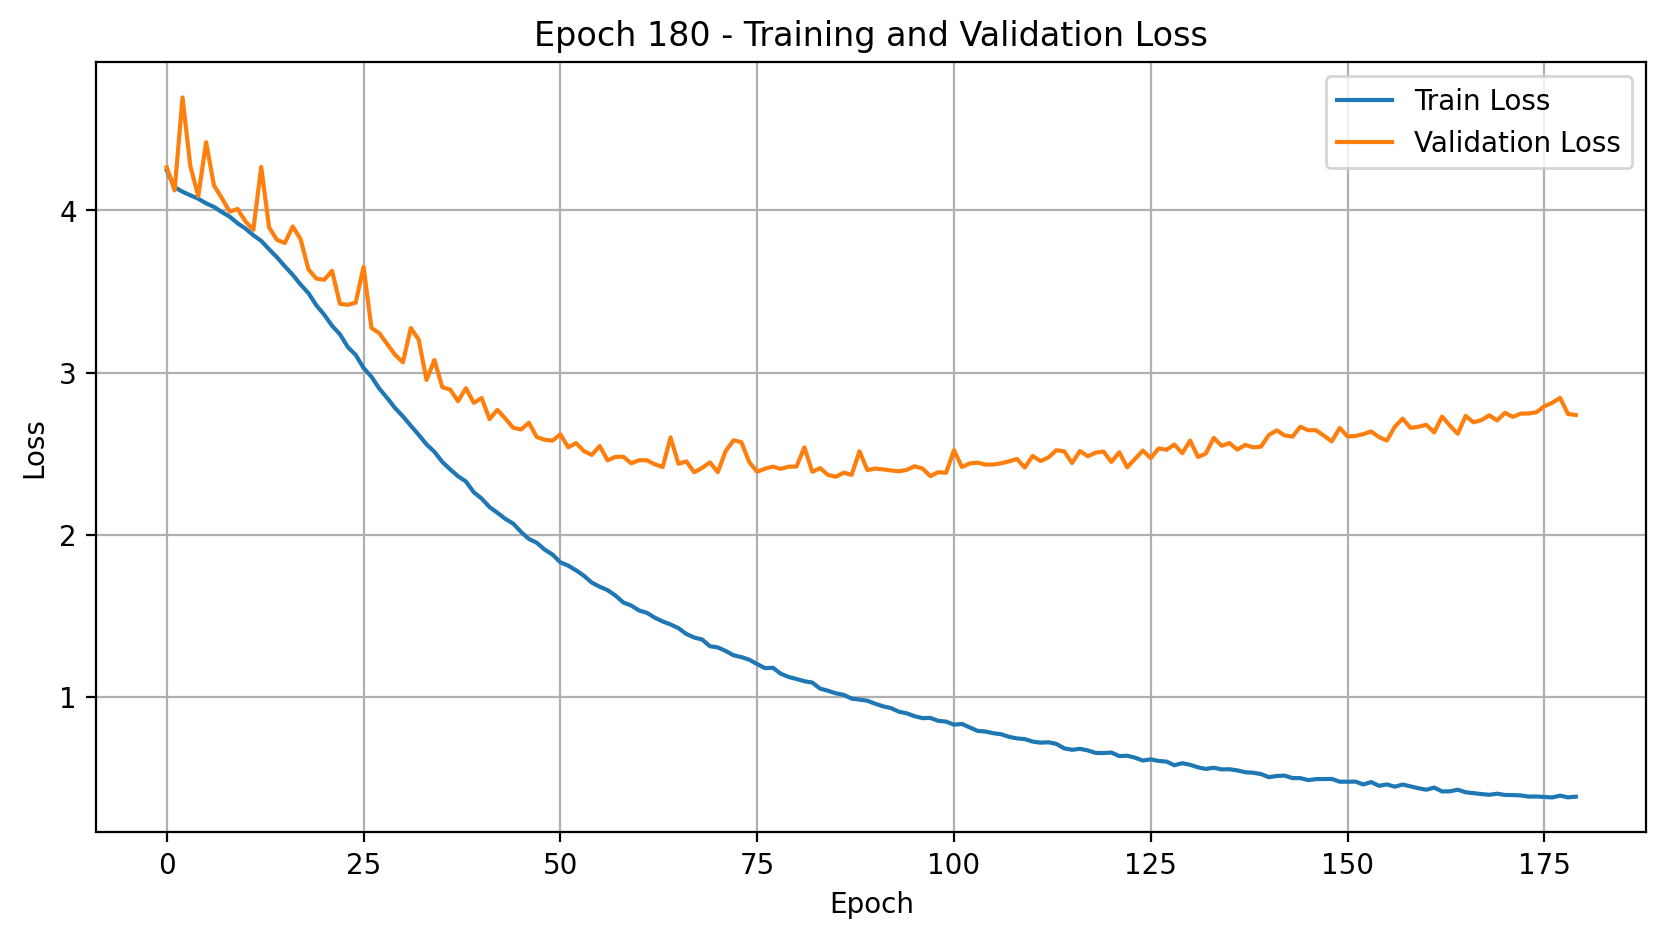

Epoch 181/200
Epoch 182/200
Epoch 183/200
Epoch 184/200
Epoch 185/200
Epoch 186/200
Epoch 187/200
Epoch 188/200
Epoch 189/200
Epoch 190/200


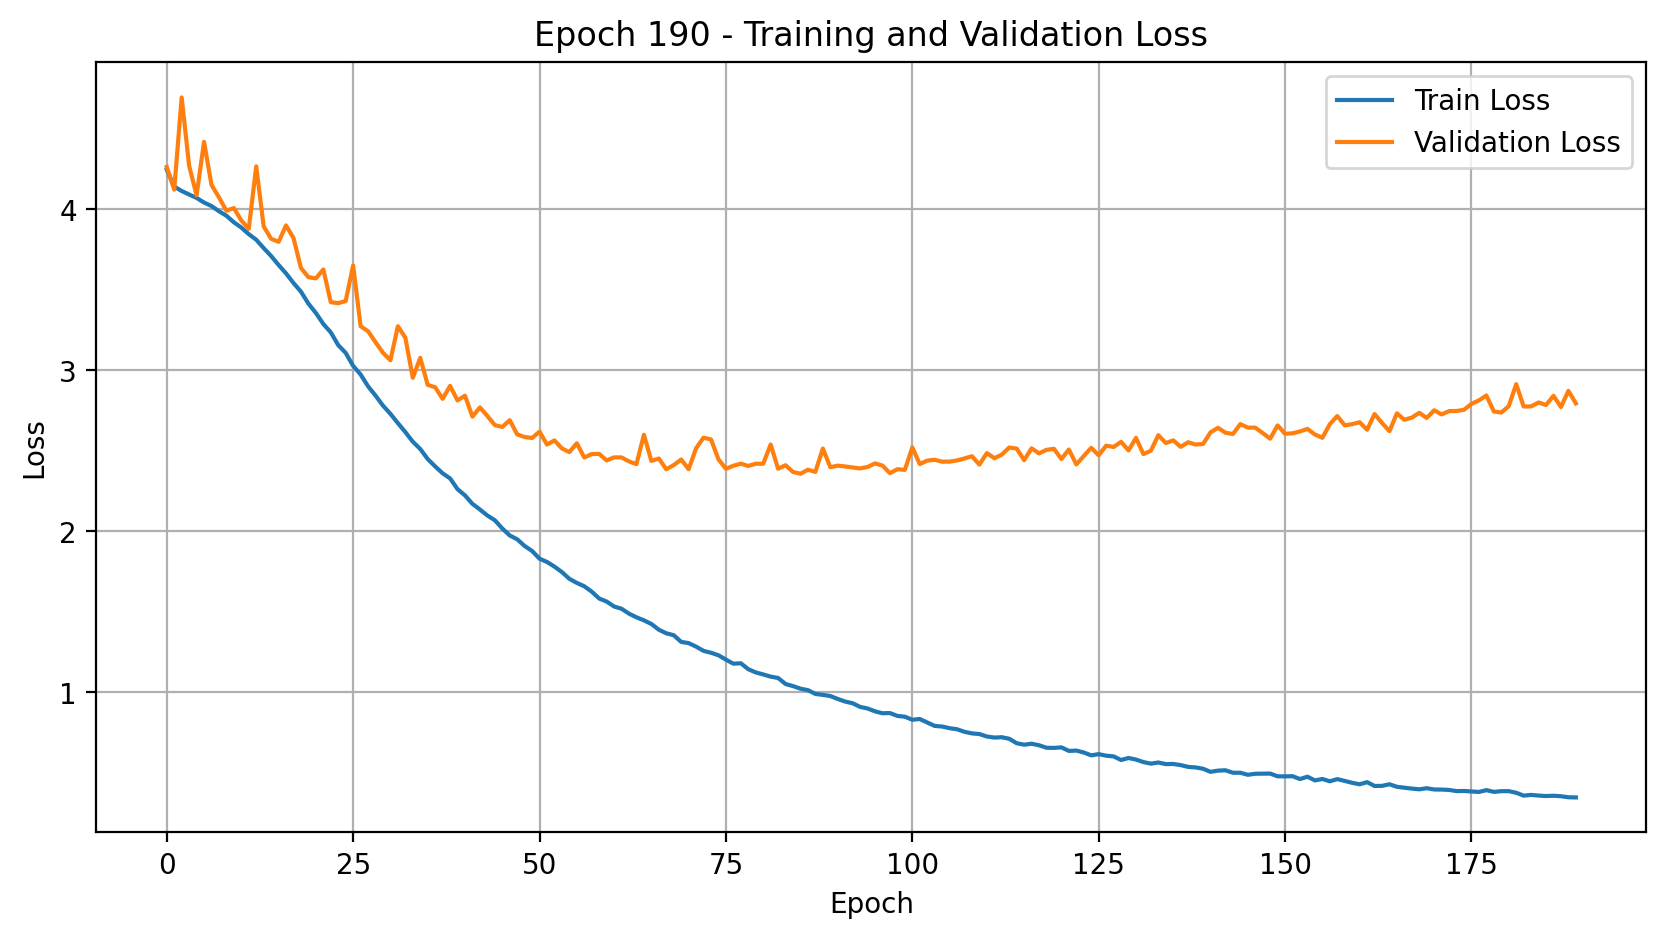

Epoch 191/200
Epoch 192/200
Epoch 193/200
Epoch 194/200
Epoch 195/200
Epoch 196/200
Epoch 197/200
Epoch 198/200
Epoch 199/200
Epoch 200/200


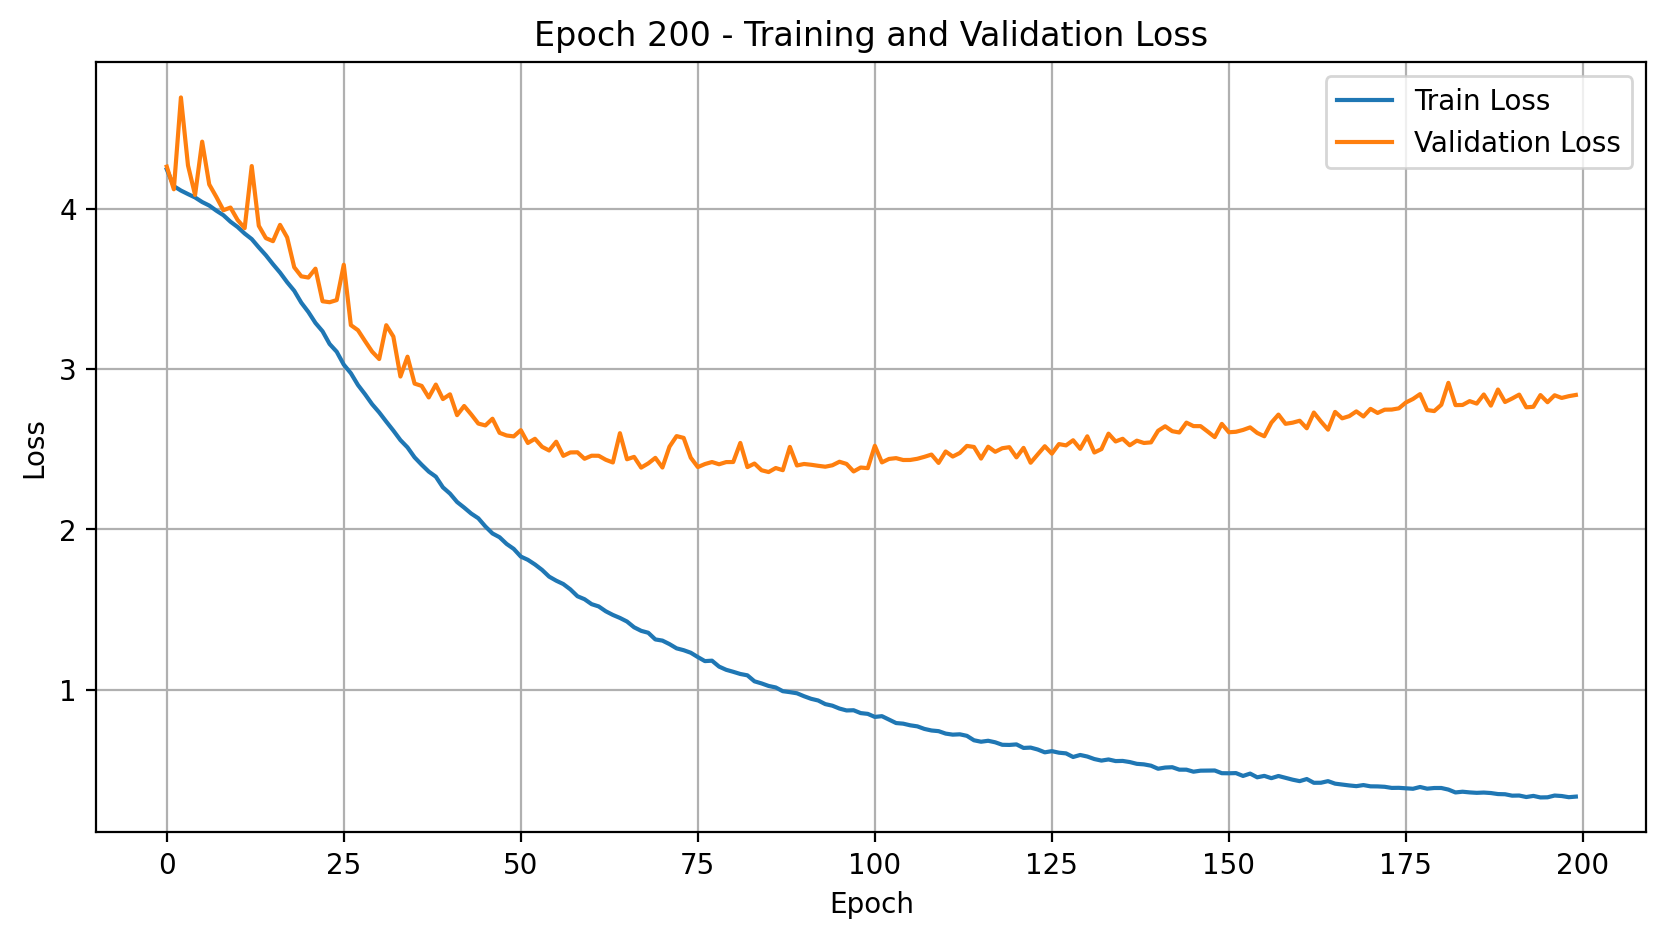

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size=X_train.shape[2], output_size=y.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

batch_size = 256
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)


epochs = 200
best_val_loss = float('inf')
patience = 5
trigger_times = 0

train_loss_history = []
val_loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    model.train()
    epoch_train_loss = 0
    epoch_val_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_loss_history.append(epoch_train_loss)

    model.eval()
    with torch.no_grad():
      for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        val_pred = model(batch_X)
        val_loss = criterion(val_pred, batch_y)
        epoch_val_loss += val_loss.item()

      val_loss_history.append(epoch_val_loss / len(val_loader))

    if epoch % 10 == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(val_loss_history, label='Validation Loss')
        plt.title(f'Epoch {epoch} - Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

In [16]:
torch.save(model.state_dict(), "drive/MyDrive/Colab Notebooks/PROGETTO SOUND COMPUTING/best_model.pth")

In [21]:
def melody_generator(note_count, model, X_test, reverse_mapping, L_symb, temperature=1.0):
    model.eval()
    with torch.no_grad():
        music = []
        notes_generated = []

        seed = X_test[np.random.randint(0, len(X_test) - 1)]

        for _ in range(note_count):
            seed_tensor = torch.tensor(seed, dtype=torch.float32).unsqueeze(0).to(device)
            prediction = model(seed_tensor).squeeze(0)
            prediction_probs = F.softmax(prediction / temperature, dim=-1).cpu().numpy()

            index = np.random.choice(len(prediction_probs), p=prediction_probs)

            index_N = index / float(L_symb)
            notes_generated.append(index)
            music.append(reverse_mapping[index])

            seed = np.append(seed, [[index_N]], axis=0)
            seed = seed[1:]

        melody = chords_n_notes(music)
        melody_midi = stream.Stream(melody)

    return music, melody_midi


music_notes, melody = melody_generator(50, model, X_test, reverse_mapping, L_symb, temperature=1.0)
melody.write('midi', 'drive/MyDrive/Colab Notebooks/PROGETTO SOUND COMPUTING/output.mid')


'drive/MyDrive/Colab Notebooks/PROGETTO SOUND COMPUTING/output.mid'